<a href="https://colab.research.google.com/github/sidtalwar/Exploratory-Data-Analysis/blob/master/examples/likelihood_and_posterior_Brock_and_Hommes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computing the likelihood and posterior for the Brock and Hommes model

In this notebook we use the LikelihoodLoss to estimate the log-likelihood and the posterior of 2 parameters of the BH4 model.

In [ ]:
!pip install git+https://github.com/bancaditalia/black-it.git
!pip install pandas numpy matplotlib tqdm torch pyro-ppl


  Cloning https://github.com/bancaditalia/black-it.git to /tmp/pip-req-build-k0y1kw30
  Running command git clone --filter=blob:none --quiet https://github.com/bancaditalia/black-it.git /tmp/pip-req-build-k0y1kw30
  Resolved https://github.com/bancaditalia/black-it.git to commit 8da1630572fc1cb572684c7d46d97c6c733498c7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 21.7 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 133.9 MB/s eta 0:00:01^C


In [1]:
import black_it
import numpy as np
import matplotlib.pyplot as plt

from black_it.calibrator import Calibrator

from black_it.loss_functions.likelihood import LikelihoodLoss
from black_it.samplers.base import BaseSampler

from scipy.special import logsumexp

%load_ext autoreload
%autoreload 2

In [2]:
def BH4(theta, N, seed):
    """
    Model from Brock and Hommes 1998.

    Eqs. (36-40) of Dyer et al., Black-box Bayesian inference for economic agent-based models (2022)

    Args:
        theta: parameters
        N: length of simulation
        seed: random seed

    Returns:
        simulated series
    """
    np.random.seed(seed=seed)

    R = 1.0
    sigma = 0.04

    beta = 120 # suggested values: 10, 120
    g1, b1, b4 = 0., 0., 0.
    g4 = 1.01

    g2, b2, g3, b3 = theta[0], theta[1], 0.9, -0.2#theta[2], theta[3]
    # parameter set1: (g2, b2, g3, b3) = (0.9, 0.2, 0.9, −0.2)
    x_lag3 = 0.0
    x_lag2 = 0.0
    x_lag1 = 0.0

    x = np.zeros(N + 2)
    n = np.full(2, 0.50)

    x[0],x[1],x[2] = x_lag1, x_lag2, x_lag3

    g = np.array([g1, g2, g3, g4])
    b = np.array([b1, b2, b3, b4])

    for t in range(3, N + 1):
        den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))

        f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R

        x[t+1] = np.random.normal(f, sigma/R)

    return np.atleast_2d(x[2:]).T


/tmp/ipython-input-4-3910915716.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


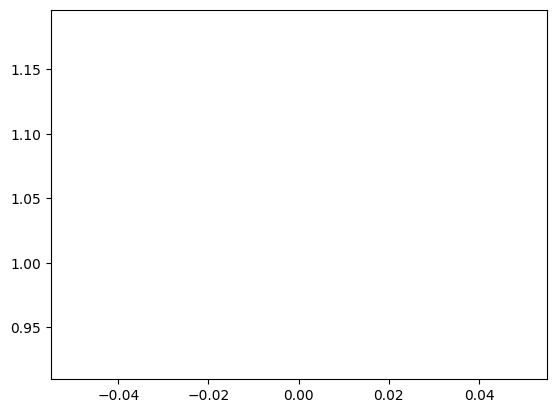

/tmp/ipython-input-3-1986782275.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


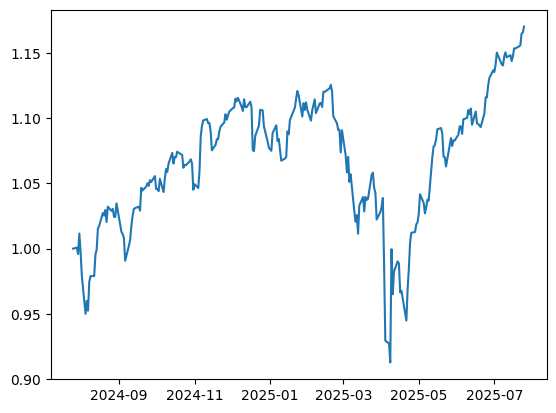

In [3]:
# Assuming spx_data DataFrame is already loaded from the previous step
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the ticker symbol for SPX
ticker_symbol = "^GSPC"  # ^GSPC is the ticker for S&P 500

# Define the end date as today
end_date = datetime.now()

# Define the start date as one year ago from today
start_date = end_date - timedelta(days=365)

# Download the historical data
spx_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Use the 'Close' column for the time series
spx_close_prices = spx_data['Close']

# Scale the SPX close prices by dividing by the first value
scaled_spx_series = spx_close_prices / spx_close_prices.iloc[0]

plt.plot(scaled_spx_series)


# Now, you need to manually modify the BH4 function (cell id: a1187ef4)
# and change the initial values:
# x_lag3 = 0.0
# x_lag2 = 0.0
# x_lag1 = 0.0

Text(0, 0.5, 'y(t)')

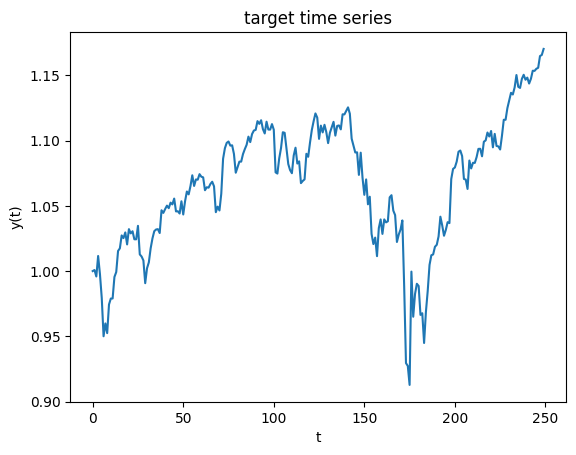

In [6]:
# synthetic target series (parameter set 1 of [Dyer et al. (2022)])
#target_series = BH4(theta = [0.5, 0], N= 500, seed=0)
# Convert the scaled series to the shape expected by the Calibrator
# Reshape to (N, 1) where N is the number of data points
target_series = np.atleast_2d(scaled_spx_series.values).T

# Correct the shape to (N, 1)
target_series = scaled_spx_series.values.reshape(-1, 1)

plt.plot(target_series)
plt.title("target time series")
plt.xlabel("t")
plt.ylabel("y(t)")

Text(0, 0.5, 'y(t)')

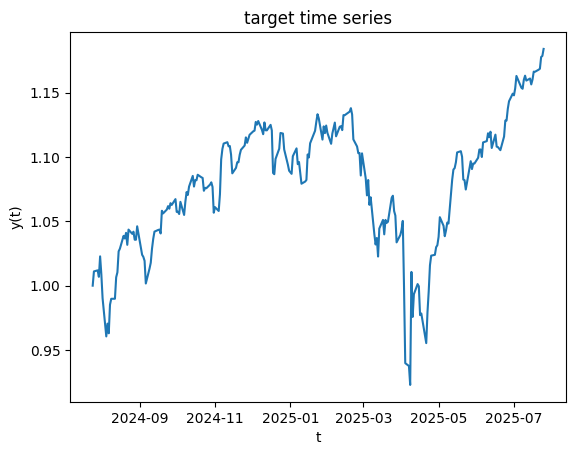

In [7]:
# Define a space of parameter combinations ("H") to explore
nx, ny = 21, 21
xs = np.linspace(0, 1, nx)
ys = np.linspace(0, 1, ny)

H = []
for x in xs:
    for y in ys:
        H.append([x, y])

H = np.array(H)

441


Text(0, 0.5, 'param 1')

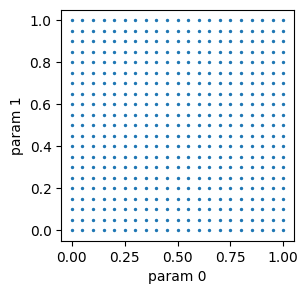

In [8]:
# grid of points we are considering
print(len(H))
plt.figure(figsize = (3, 3))
plt.scatter(H[:, 0], H[:, 1], s = 2.0)
plt.xlabel("param 0")
plt.ylabel("param 1")

In [9]:
# define a "dummy" sampler which simply returns the grid of paramerers to explore
class HSampler(BaseSampler):

    def sample_batch(
        self,
        batch_size,
        search_space,
        existing_points,
        existing_losses):

        return H

In [10]:
# initialise dummy sampler and a likelihood loss
dymmy_sampler = HSampler(batch_size = len(H))
loss = LikelihoodLoss(h = 'silverman') # use the Silverman's rule of thumb

In [11]:
# define some bounds and precisions
bounds = [[0.0, 0.0],
          [1.0, 1.0]]

precisions = [0.001, 0.001]

In [12]:
# initialise a calibrator object
cal = Calibrator(
    samplers=[dymmy_sampler],
    loss_function=loss,
    model=BH4,
    parameters_bounds=bounds,
    sim_length = 1000,   # simulation length for each parameter combination
    ensemble_size=1,     # number of repetitions for each parameter combination
    parameters_precision=precisions,
    real_data=target_series,
    random_state=1,
)


***
Number of free params:       2.
Explorable param space size: 1002001.
***

Selecting 2 processes for the parallel evaluation of the model


/usr/local/lib/python3.11/dist-packages/black_it/calibrator.py:109: RuntimeWarning: The length of real time series is different from the simulation length, got 250 and 1000. This may or may not be a problem depending on the loss function used.
  warnings.warn(  # noqa: B028


In [13]:
# calibrate for a single epoch over the grid
params, losses = cal.calibrate(1)



BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: HSampler
----> sim exec elapsed time: 17.0s
---->   min loss new params: nan
---->   avg loss new params: nan
----> avg loss exist params: nan
---->         curr min loss: nan
====>    total elapsed time: 17.0s


In [14]:
# substitute NaN values with maximum loss values
max_loss = np.nanmax(losses)
losses[np.isnan(losses)] = max_loss

In [15]:
# compute posterior probability
log_likelihood = -losses

prior = np.ones(len(H)) * 1.0/len(H)

log_posterior = log_likelihood + np.log(prior) - logsumexp(log_likelihood + np.log(prior))

posterior = np.exp(log_posterior)

In [16]:
# check normalisation of the posterior
sum(posterior)

0.9999999999999957

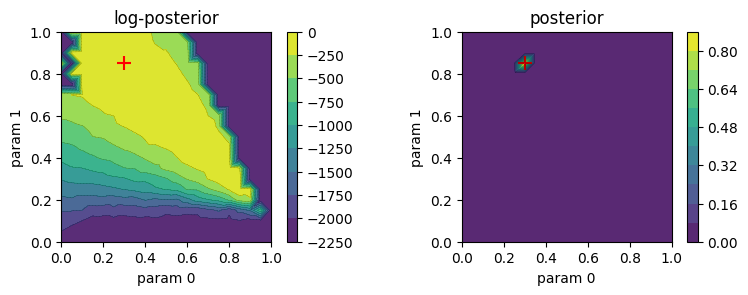

In [17]:
# plot the log posterior over a 2D grid

levels = 10
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (8, 3))
ax = axes[0]

ax.set_aspect('equal')
tcf = ax.tricontourf(params[:, 0], params[:, 1], log_posterior, levels=levels, alpha=0.9 )
fig.colorbar(tcf)
ax.tricontour(params[:, 0], params[:, 1], log_posterior, levels=levels, alpha=0.8, colors='k', linewidths = 0.2)
ax.set_title('log-posterior')
ax.scatter(params[0, 0], params[0, 1], color = 'r', marker = '+', s = 100)
ax.set_xlabel("param 0")
ax.set_ylabel("param 1")

ax = axes[1]
ax.set_aspect('equal')
tcf = ax.tricontourf(params[:, 0], params[:, 1], posterior, levels=levels, alpha=0.9 )
fig.colorbar(tcf)
ax.tricontour(params[:, 0], params[:, 1], posterior, levels=levels, alpha=0.8, colors='k', linewidths = 0.2)
ax.set_title('posterior')
ax.scatter(params[0, 0], params[0, 1], color = 'r', marker = '+', s = 100)
ax.set_xlabel("param 0")
ax.set_ylabel("param 1")

plt.tight_layout()

MAP parameters:  [0.3  0.85]


Text(0, 0.5, 'y(t)')

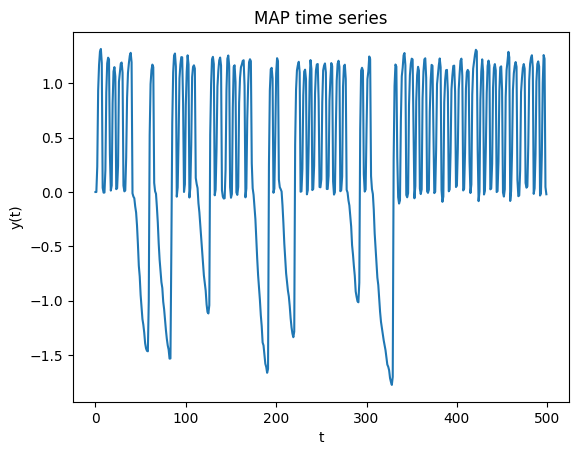

In [18]:
# maximum-a-posterior (MAP) parametes and MAP time series
print("MAP parameters: ", params[0])
best_series = BH4(theta = params[0], N= 500, seed=0)
plt.plot(best_series);
plt.title("MAP time series")
plt.xlabel("t")
plt.ylabel("y(t)")

In [19]:
# obtain empirical marginal distributions over single parameters
p0s = list(set(params[:, 0]))
p0s.sort()
p1s = list(set(params[:, 1]))
p1s.sort()

posterior_p0s = []
for p0 in p0s:
    idx = params[:, 0] == p0
    l = np.sum(posterior[idx])
    posterior_p0s.append(l)

posterior_p0s = np.array(posterior_p0s)

posterior_p1s = []
for p1 in p1s:
    idx = params[:, 1] == p1
    l = np.sum(posterior[idx])
    posterior_p1s.append(l)

posterior_p1s = np.array(posterior_p1s)

Text(0, 0.5, 'marginal posterior')

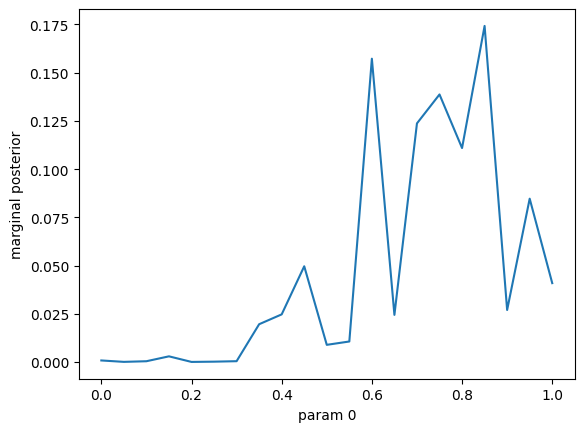

In [ ]:
plt.plot(p0s, posterior_p0s)
plt.xlabel('param 0')
plt.ylabel('marginal posterior')

Text(0, 0.5, 'marginal posterior')

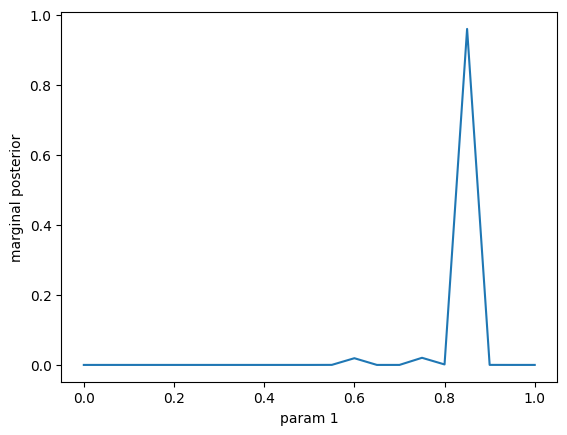

In [20]:
plt.plot(p1s, posterior_p1s)
plt.xlabel('param 1')
plt.ylabel('marginal posterior')

In [5]:
print(target_series.shape)
print(target_series)

(1, 250)
[[1.         1.00081331 0.9958491  1.01157695 0.99772491 0.97938487
  0.95003389 0.95987062 0.95244636 0.97439321 0.97894526 0.97898739
  0.99548095 0.9992874  1.01540915 1.01742959 1.02732133 1.02528256
  1.02962943 1.02043195 1.03214994 1.02889483 1.03053611 1.02437766
  1.02433732 1.03467601 1.0127915  1.01116846 1.00811673 0.99071639
  1.00218895 1.00667141 1.01740759 1.02503337 1.03057645 1.03187151
  1.03214449 1.02915493 1.04662674 1.04459521 1.04752976 1.0501603
  1.04820569 1.05243905 1.05112011 1.05557324 1.04573096 1.04587568
  1.04411713 1.05348312 1.04338441 1.05349413 1.06098806 1.05879169
  1.06519933 1.07340954 1.06524146 1.07022588 1.0700427  1.07429243
  1.07233424 1.07182504 1.06197355 1.06425231 1.06393362 1.06675458
  1.06847646 1.06495023 1.0451265  1.04940369 1.04645268 1.0592881
  1.08608377 1.09415471 1.09826527 1.09932956 1.09614957 1.09640413
  1.08977117 1.07538239 1.07959554 1.08387461 1.0838984  1.08968692
  1.09346591 1.0967687  1.10304442 1.0988